In [1]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
from aequitas.group import Group
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

result_v_model = pd.DataFrame()
datasets = ['Variant I.csv', 'Variant II.csv', 'Variant III.csv', 'Variant IV.csv', 'Variant V.csv']
for dataset in datasets:
    data = pd.read_csv(dataset)

    # 공통 코드: ROC Curve 시각화
    def plot_roc(fpr, tpr):
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label='ROC curve')
        plt.axvline(x=0.05, color='red', linestyle='--', label='FPR = 5%')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC curve')
        plt.legend(loc="lower right")
        plt.grid()
        plt.show()

    # 공통 코드: 공정성 지표 생성
    def get_fairness_metrics(y_true, y_pred, groups, FIXED_FPR):
        g = Group()
        aequitas_df = pd.DataFrame(
            {"score": y_pred,
             "label_value": y_true,
             "group": groups}
        )
        disparities_df = g.get_crosstabs(aequitas_df, score_thresholds={"score_val": [FIXED_FPR]})[0]
        predictive_equality = disparities_df["fpr"].min() / disparities_df["fpr"].max()
        return predictive_equality, disparities_df

    # 공통 코드: 평가 함수
    def evaluate(predictions, FIXED_FPR=0.05):
        fprs, tprs, thresholds = roc_curve(y_test, predictions)
        plot_roc(fprs, tprs)  # 공통 코드 호출

        valid_indices = np.where(fprs <= FIXED_FPR)[0]
        if len(valid_indices) > 0:
            tpr = tprs[valid_indices][-1]
            fpr = fprs[valid_indices][-1]
            threshold = thresholds[valid_indices][-1]
        else:
            tpr = 0.0
            fpr = FIXED_FPR
            threshold = None

        auc = roc_auc_score(y_test, predictions)
        predictive_equality, disparities_df = get_fairness_metrics(y_test, predictions, groups_test, FIXED_FPR)

        # 출력 형식
        to_pct = lambda x: f"{x * 100:.2f}%"
        print(f"AUC: {auc:.4f}")
        print(f"TPR:  {to_pct(tpr)}")
        print(f"FPR:  {to_pct(fpr)}")
        print(f"Threshold:  {threshold:.2f}" if threshold is not None else "Threshold: N/A")
        print(f"Predictive Equality:  {to_pct(predictive_equality)}")

        return tpr, predictive_equality

    # 1. 데이터 로드 및 분리

    # 전체가 0인 device_fraud_count 컬럼 삭제
    data.drop('device_fraud_count', axis=1, inplace=True)

    # month 기준으로 데이터 분리
    train_data = data[data['month'] < 6]
    test_data = data[data['month'] >= 6]

    # 학습 데이터와 테스트 데이터 분리
    X_train = train_data.drop(columns=['fraud_bool'])
    y_train = train_data['fraud_bool']
    X_test = test_data.drop(columns=['fraud_bool'])
    y_test = test_data['fraud_bool']

    X_train.drop('month', axis=1, inplace=True)
    X_test.drop('month', axis=1, inplace=True)

    print(f"Train Data: {X_train.shape}, {y_train.shape}")
    print(f"Test Data: {X_test.shape}, {y_test.shape}")

    # 2. 언더샘플링
    fraud_sample = train_data[train_data['fraud_bool'] == 1].sample(n=8000, random_state=0)
    non_fraud_sample = train_data[train_data['fraud_bool'] == 0].sample(n=8000, random_state=0)

    # 언더샘플링된 학습 데이터 생성
    undersampled_data = pd.concat([fraud_sample, non_fraud_sample]).sample(frac=1, random_state=0)
    X_train_undersampled = undersampled_data.drop(columns=['fraud_bool'])
    y_train_undersampled = undersampled_data['fraud_bool']

    print(f"Undersampled Train Data: {X_train_undersampled.shape}, {y_train_undersampled.shape}")

    # 3. 범주형 변수 인코딩
    categorical_columns = X_train_undersampled.select_dtypes(include=['object']).columns
    X_train_undersampled = pd.get_dummies(X_train_undersampled, columns=categorical_columns, drop_first=True)
    X_test = pd.get_dummies(X_test, columns=categorical_columns, drop_first=True)

    # 테스트 데이터와 학습 데이터의 열 맞춤
    X_test = X_test.reindex(columns=X_train_undersampled.columns, fill_value=0)

    # 4. 데이터 스케일링
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_undersampled)
    X_test_scaled = scaler.transform(X_test)

    # 5. 그룹 정의
    groups = (data["customer_age"] > 50).map({True: ">50", False: "<=50"})
    groups_test = groups.loc[X_test.index]

    # 6. 모델 리스트 정의
    models = [
        ("Gradient Boosting", GradientBoostingClassifier(random_state=0)),
        ('LightGBM', LGBMClassifier(boosting_type='gbdt', learning_rate=0.1, max_depth=3, n_estimators=150, num_leaves=15, boost_from_average=False)),
    ]

    # 7. 모델 평가
    model_results = []
    for name, model in models:
        try:
            # 학습 데이터 선택
            X_train_data = X_train_scaled if name in ["Logistic Regression", "SVM"] else X_train_undersampled
            X_test_data = X_test_scaled if name in ["Logistic Regression", "SVM"] else X_test

            # 모델 학습
            model.fit(X_train_data, y_train_undersampled)

            # 테스트 데이터 예측
            y_proba = model.predict_proba(X_test_data)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test_data)

            # 평가
            print(f"Evaluating {name}...")
            tpr, fairness = evaluate(y_proba, FIXED_FPR=0.05)

            # 결과 저장
            model_results.append((dataset[:-4] + ' : ' + name, tpr, fairness))
        except Exception as e:
            print(f"Error with {name}: {e}")

    # 8. 결과 데이터프레임 생성
    results_df = pd.DataFrame(model_results, columns=["Model", "TPR at FPR=5%", "Fairness Predictive Equality"])

    # 퍼센트 포맷 적용
    results_df["TPR at FPR=5%"] = results_df["TPR at FPR=5%"].apply(lambda x: f"{x * 100:.2f}%")
    results_df["Fairness Predictive Equality"] = results_df["Fairness Predictive Equality"].apply(lambda x: f"{x * 100:.2f}%")

    # 결과 출력
    print("\nModel Performance Summary:")
    display(results_df)
    result_v_model = pd.concat([result_v_model, results_df])


ModuleNotFoundError: No module named 'aequitas'

In [ ]:
result_v_model

,Model,TPR at FPR=5%,Fairness Predictive Equality
0,Variant I : Gradient Boosting,49.55%,98.99%
1,Variant I : LightGBM,50.66%,98.43%
0,Variant II : Gradient Boosting,52.26%,93.99%
1,Variant II : LightGBM,53.34%,88.78%
0,Variant III : Gradient Boosting,73.91%,72.05%
1,Variant III : LightGBM,74.81%,67.81%
0,Variant IV : Gradient Boosting,40.42%,90.36%
1,Variant IV : LightGBM,41.74%,86.68%
0,Variant V : Gradient Boosting,32.32%,71.16%
1,Variant V : LightGBM,34.20%,65.91%


Train Data: (794990, 29), (794990,)
Test Data: (205010, 29), (205010,)
Evaluating LogisticRegression...


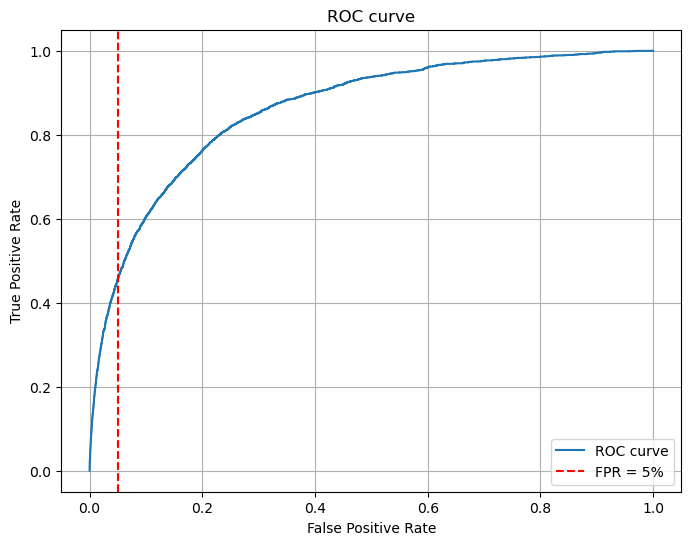

AUC: 0.8612
TPR:  45.66%
FPR:  4.99%
Threshold:  0.76
Predictive Equality:  97.72%
[LightGBM] [Info] Number of positive: 8151, number of negative: 786839
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033975 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3251
[LightGBM] [Info] Number of data points in the train set: 794990, number of used features: 45
Evaluating LightGBM...


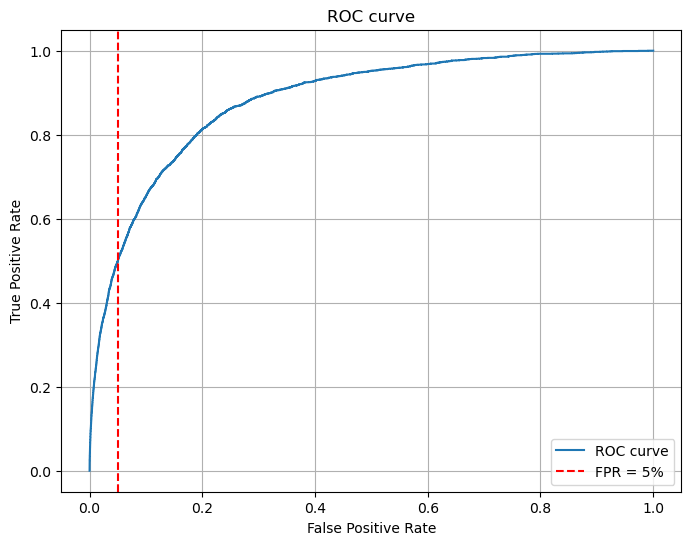

AUC: 0.8829
TPR:  49.93%
FPR:  5.00%
Threshold:  0.04
Predictive Equality:  65.79%

Model Performance Summary:


,Model,TPR at FPR=5%,Fairness Predictive Equality
0,Variant I : LogisticRegression,45.66%,97.72%
1,Variant I : LightGBM,49.93%,65.79%


Train Data: (794990, 29), (794990,)
Test Data: (205010, 29), (205010,)
Evaluating LogisticRegression...


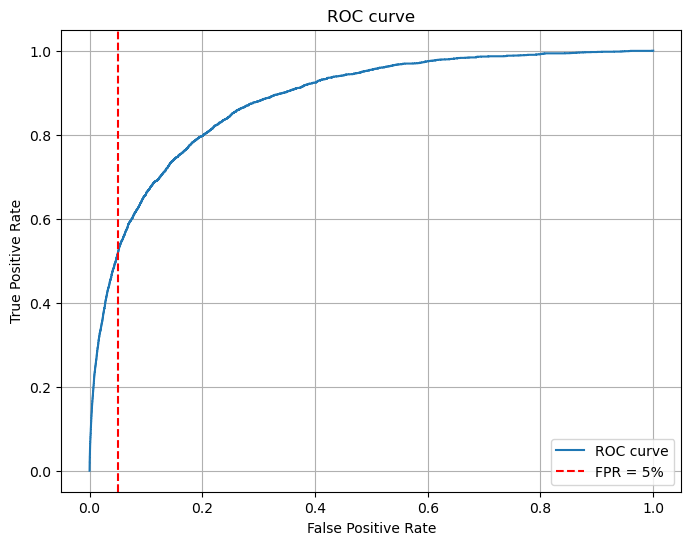

AUC: 0.8828
TPR:  51.70%
FPR:  4.99%
Threshold:  0.78
Predictive Equality:  82.02%
[LightGBM] [Info] Number of positive: 8151, number of negative: 786839
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3251
[LightGBM] [Info] Number of data points in the train set: 794990, number of used features: 45
Evaluating LightGBM...


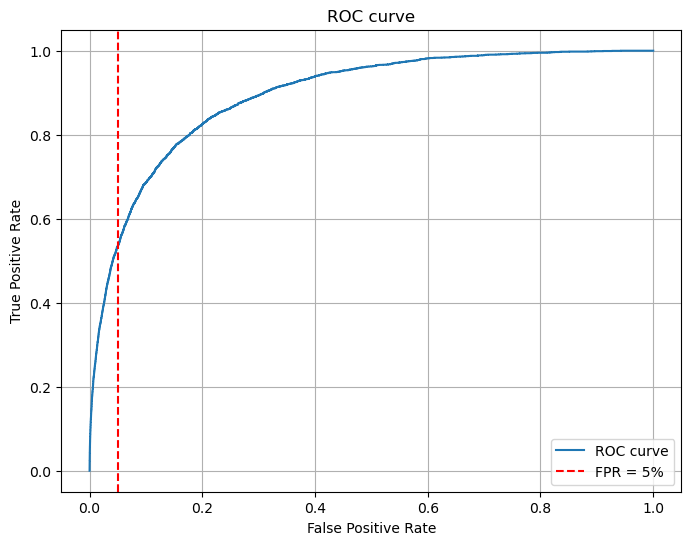

AUC: 0.8941
TPR:  53.47%
FPR:  5.00%
Threshold:  0.04
Predictive Equality:  31.83%

Model Performance Summary:


,Model,TPR at FPR=5%,Fairness Predictive Equality
0,Variant II : LogisticRegression,51.70%,82.02%
1,Variant II : LightGBM,53.47%,31.83%


Train Data: (758328, 31), (758328,)
Test Data: (241672, 31), (241672,)
Evaluating LogisticRegression...


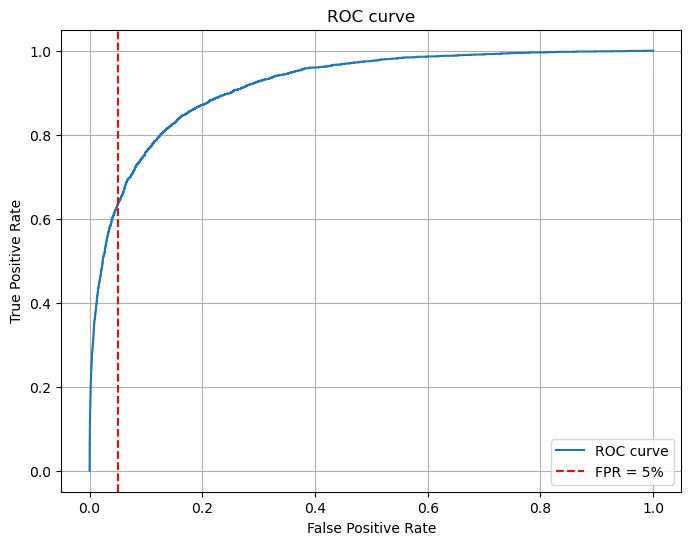

AUC: 0.9191
TPR:  63.46%
FPR:  4.99%
Threshold:  0.76
Predictive Equality:  74.58%
[LightGBM] [Info] Number of positive: 8378, number of negative: 749950
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039827 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3760
[LightGBM] [Info] Number of data points in the train set: 758328, number of used features: 47
Evaluating LightGBM...


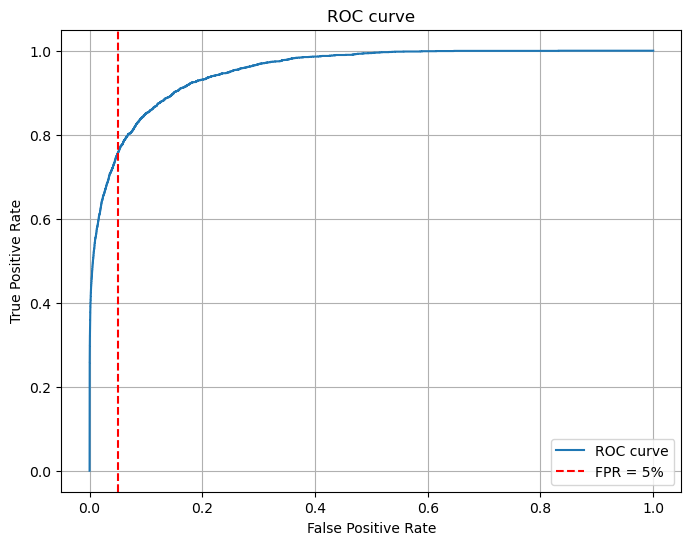

AUC: 0.9531
TPR:  75.60%
FPR:  4.99%
Threshold:  0.02
Predictive Equality:  36.32%

Model Performance Summary:


,Model,TPR at FPR=5%,Fairness Predictive Equality
0,Variant III : LogisticRegression,63.46%,74.58%
1,Variant III : LightGBM,75.60%,36.32%


Train Data: (758328, 29), (758328,)
Test Data: (241672, 29), (241672,)
Evaluating LogisticRegression...


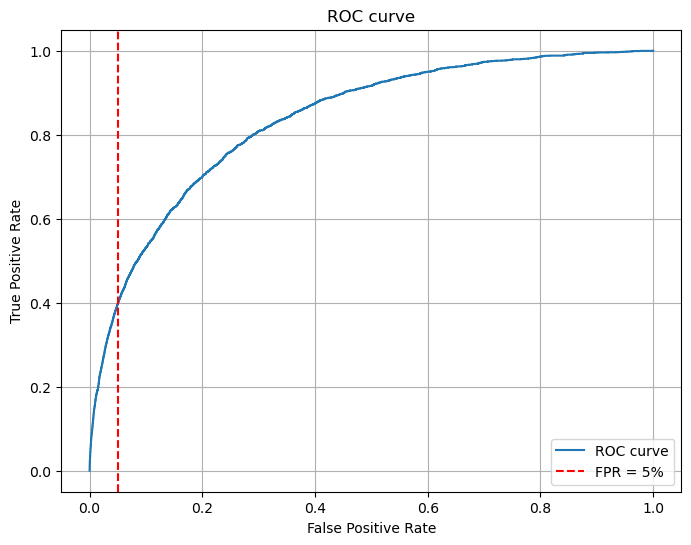

AUC: 0.8348
TPR:  39.67%
FPR:  4.97%
Threshold:  0.79
Predictive Equality:  81.51%
[LightGBM] [Info] Number of positive: 8378, number of negative: 749950
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3249
[LightGBM] [Info] Number of data points in the train set: 758328, number of used features: 45
Evaluating LightGBM...


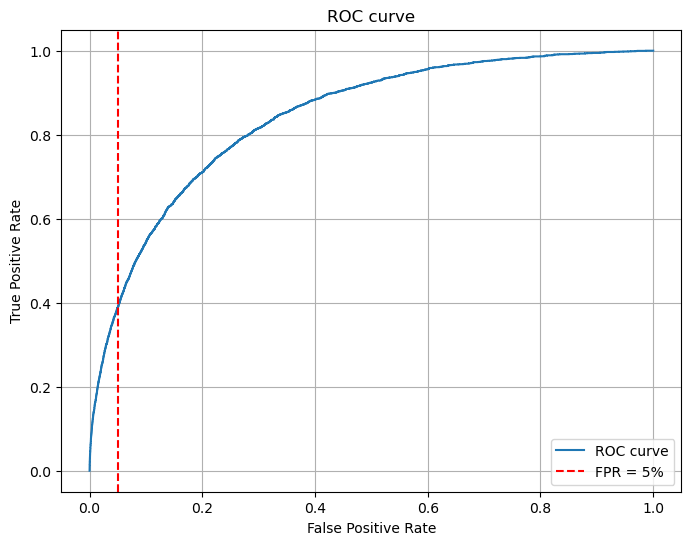

AUC: 0.8407
TPR:  38.88%
FPR:  4.98%
Threshold:  0.04
Predictive Equality:  32.02%

Model Performance Summary:


,Model,TPR at FPR=5%,Fairness Predictive Equality
0,Variant IV : LogisticRegression,39.67%,81.51%
1,Variant IV : LightGBM,38.88%,32.02%


Train Data: (758328, 31), (758328,)
Test Data: (241672, 31), (241672,)
Evaluating LogisticRegression...


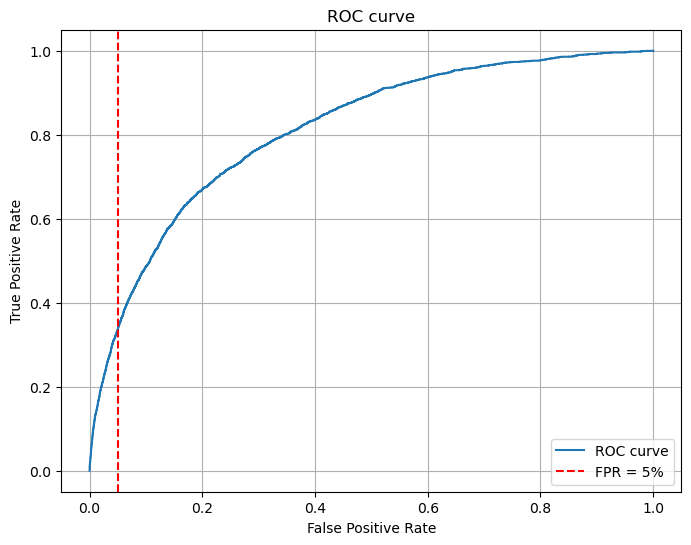

AUC: 0.8119
TPR:  33.67%
FPR:  4.99%
Threshold:  0.76
Predictive Equality:  75.17%
[LightGBM] [Info] Number of positive: 8378, number of negative: 749950
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3759
[LightGBM] [Info] Number of data points in the train set: 758328, number of used features: 47
Evaluating LightGBM...


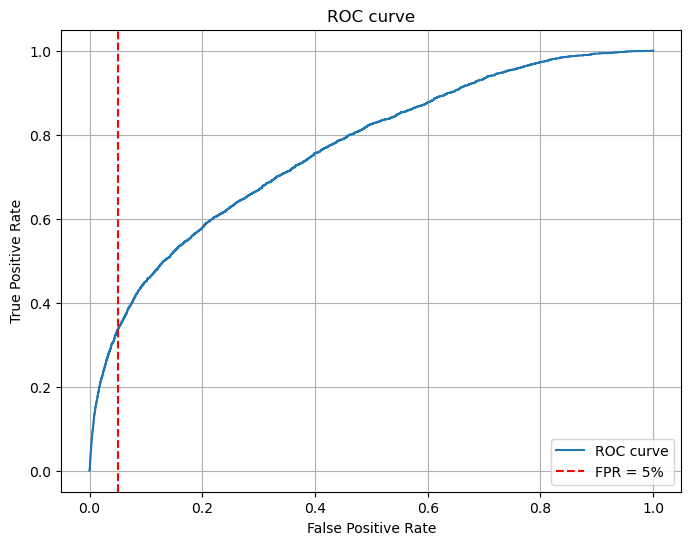

AUC: 0.7651
TPR:  33.60%
FPR:  4.99%
Threshold:  0.03
Predictive Equality:  40.80%

Model Performance Summary:


,Model,TPR at FPR=5%,Fairness Predictive Equality
0,Variant V : LogisticRegression,33.67%,75.17%
1,Variant V : LightGBM,33.60%,40.80%


In [ ]:
result_v_model_org = pd.DataFrame()
datasets = ['Variant I.csv', 'Variant II.csv', 'Variant III.csv', 'Variant IV.csv', 'Variant V.csv']
for dataset in datasets:
    data = pd.read_csv(dataset)

    # 공통 코드: ROC Curve 시각화
    def plot_roc(fpr, tpr):
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label='ROC curve')
        plt.axvline(x=0.05, color='red', linestyle='--', label='FPR = 5%')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC curve')
        plt.legend(loc="lower right")
        plt.grid()
        plt.show()

    # 공통 코드: 공정성 지표 생성
    def get_fairness_metrics(y_true, y_pred, groups, FIXED_FPR):
        g = Group()
        aequitas_df = pd.DataFrame(
            {"score": y_pred,
             "label_value": y_true,
             "group": groups}
        )
        disparities_df = g.get_crosstabs(aequitas_df, score_thresholds={"score_val": [FIXED_FPR]})[0]
        predictive_equality = disparities_df["fpr"].min() / disparities_df["fpr"].max()
        return predictive_equality, disparities_df

    # 공통 코드: 평가 함수
    def evaluate(predictions, FIXED_FPR=0.05):
        fprs, tprs, thresholds = roc_curve(y_test, predictions)
        plot_roc(fprs, tprs)  # 공통 코드 호출

        valid_indices = np.where(fprs <= FIXED_FPR)[0]
        if len(valid_indices) > 0:
            tpr = tprs[valid_indices][-1]
            fpr = fprs[valid_indices][-1]
            threshold = thresholds[valid_indices][-1]
        else:
            tpr = 0.0
            fpr = FIXED_FPR
            threshold = None

        auc = roc_auc_score(y_test, predictions)
        predictive_equality, disparities_df = get_fairness_metrics(y_test, predictions, groups_test, FIXED_FPR)

        # 출력 형식
        to_pct = lambda x: f"{x * 100:.2f}%"
        print(f"AUC: {auc:.4f}")
        print(f"TPR:  {to_pct(tpr)}")
        print(f"FPR:  {to_pct(fpr)}")
        print(f"Threshold:  {threshold:.2f}" if threshold is not None else "Threshold: N/A")
        print(f"Predictive Equality:  {to_pct(predictive_equality)}")

        return tpr, predictive_equality

    # 1. 데이터 로드 및 분리

    # 전체가 0인 device_fraud_count 컬럼 삭제
    data.drop('device_fraud_count', axis=1, inplace=True)

    # month 기준으로 데이터 분리
    train_data = data[data['month'] < 6]
    test_data = data[data['month'] >= 6]

    # 학습 데이터와 테스트 데이터 분리
    X_train = train_data.drop(columns=['fraud_bool'])
    y_train = train_data['fraud_bool']
    X_test = test_data.drop(columns=['fraud_bool'])
    y_test = test_data['fraud_bool']

    X_train.drop('month', axis=1, inplace=True)
    X_test.drop('month', axis=1, inplace=True)

    print(f"Train Data: {X_train.shape}, {y_train.shape}")
    print(f"Test Data: {X_test.shape}, {y_test.shape}")

    # 3. 범주형 변수 인코딩
    categorical_columns = X_train.select_dtypes(include=['object']).columns
    X_train = pd.get_dummies(X_train, columns=categorical_columns, drop_first=True)
    X_test = pd.get_dummies(X_test, columns=categorical_columns, drop_first=True)

    # 테스트 데이터와 학습 데이터의 열 맞춤
    X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

    # 4. 데이터 스케일링
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 5. 그룹 정의
    groups = (data["customer_age"] > 50).map({True: ">50", False: "<=50"})
    groups_test = groups.loc[X_test.index]

    # 6. 모델 리스트 정의
    models = [
        ("LogisticRegression", LogisticRegression(random_state=0, max_iter=1000, class_weight='balanced')),
        ('LightGBM', LGBMClassifier(boost_from_average=False)),
    ]

    # 7. 모델 평가
    model_results = []
    for name, model in models:
        try:
            # 모델 학습
            model.fit(X_train_scaled, y_train)

            # 테스트 데이터 예측
            y_proba = model.predict_proba(X_test_scaled)[:, 1]

            # 평가
            print(f"Evaluating {name}...")
            tpr, fairness = evaluate(y_proba, FIXED_FPR=0.05)

            # 결과 저장
            model_results.append((dataset[:-4] + ' : ' + name, tpr, fairness))
        except Exception as e:
            print(f"Error with {name}: {e}")

    # 8. 결과 데이터프레임 생성
    results_df = pd.DataFrame(model_results, columns=["Model", "TPR at FPR=5%", "Fairness Predictive Equality"])

    # 퍼센트 포맷 적용
    results_df["TPR at FPR=5%"] = results_df["TPR at FPR=5%"].apply(lambda x: f"{x * 100:.2f}%")
    results_df["Fairness Predictive Equality"] = results_df["Fairness Predictive Equality"].apply(lambda x: f"{x * 100:.2f}%")

    # 결과 출력
    print("\nModel Performance Summary:")
    display(results_df)
    result_v_model_org = pd.concat([result_v_model_org, results_df])


In [ ]:
result_v_model_org

,Model,TPR at FPR=5%,Fairness Predictive Equality
0,Variant I : LogisticRegression,45.66%,97.72%
1,Variant I : LightGBM,49.93%,65.79%
0,Variant II : LogisticRegression,51.70%,82.02%
1,Variant II : LightGBM,53.47%,31.83%
0,Variant III : LogisticRegression,63.46%,74.58%
1,Variant III : LightGBM,75.60%,36.32%
0,Variant IV : LogisticRegression,39.67%,81.51%
1,Variant IV : LightGBM,38.88%,32.02%
0,Variant V : LogisticRegression,33.67%,75.17%
1,Variant V : LightGBM,33.60%,40.80%


In [ ]:
result_v_model

,Model,TPR at FPR=5%,Fairness Predictive Equality
0,Variant I : Gradient Boosting,49.55%,98.99%
1,Variant I : LightGBM,50.66%,98.43%
0,Variant II : Gradient Boosting,52.26%,93.99%
1,Variant II : LightGBM,53.34%,88.78%
0,Variant III : Gradient Boosting,73.91%,72.05%
1,Variant III : LightGBM,74.81%,67.81%
0,Variant IV : Gradient Boosting,40.42%,90.36%
1,Variant IV : LightGBM,41.74%,86.68%
0,Variant V : Gradient Boosting,32.32%,71.16%
1,Variant V : LightGBM,34.20%,65.91%


In [ ]:
result_v_model_org = pd.DataFrame(result_v_model_org.values, columns=result_v_model_org.columns, index=range(result_v_model_org.shape[0]))

In [ ]:
result_v_model = pd.DataFrame(result_v_model.values, columns=result_v_model.columns, index=range(result_v_model.shape[0]))

In [ ]:
result_v_model_org

,Model,TPR at FPR=5%,Fairness Predictive Equality
0,Variant I : LogisticRegression,45.66%,97.72%
1,Variant I : LightGBM,49.93%,65.79%
2,Variant II : LogisticRegression,51.70%,82.02%
3,Variant II : LightGBM,53.47%,31.83%
4,Variant III : LogisticRegression,63.46%,74.58%
5,Variant III : LightGBM,75.60%,36.32%
6,Variant IV : LogisticRegression,39.67%,81.51%
7,Variant IV : LightGBM,38.88%,32.02%
8,Variant V : LogisticRegression,33.67%,75.17%
9,Variant V : LightGBM,33.60%,40.80%


In [ ]:
result_v_model

,Model,TPR at FPR=5%,Fairness Predictive Equality
0,Variant I : Gradient Boosting,49.55%,98.99%
1,Variant I : LightGBM,50.66%,98.43%
2,Variant II : Gradient Boosting,52.26%,93.99%
3,Variant II : LightGBM,53.34%,88.78%
4,Variant III : Gradient Boosting,73.91%,72.05%
5,Variant III : LightGBM,74.81%,67.81%
6,Variant IV : Gradient Boosting,40.42%,90.36%
7,Variant IV : LightGBM,41.74%,86.68%
8,Variant V : Gradient Boosting,32.32%,71.16%
9,Variant V : LightGBM,34.20%,65.91%


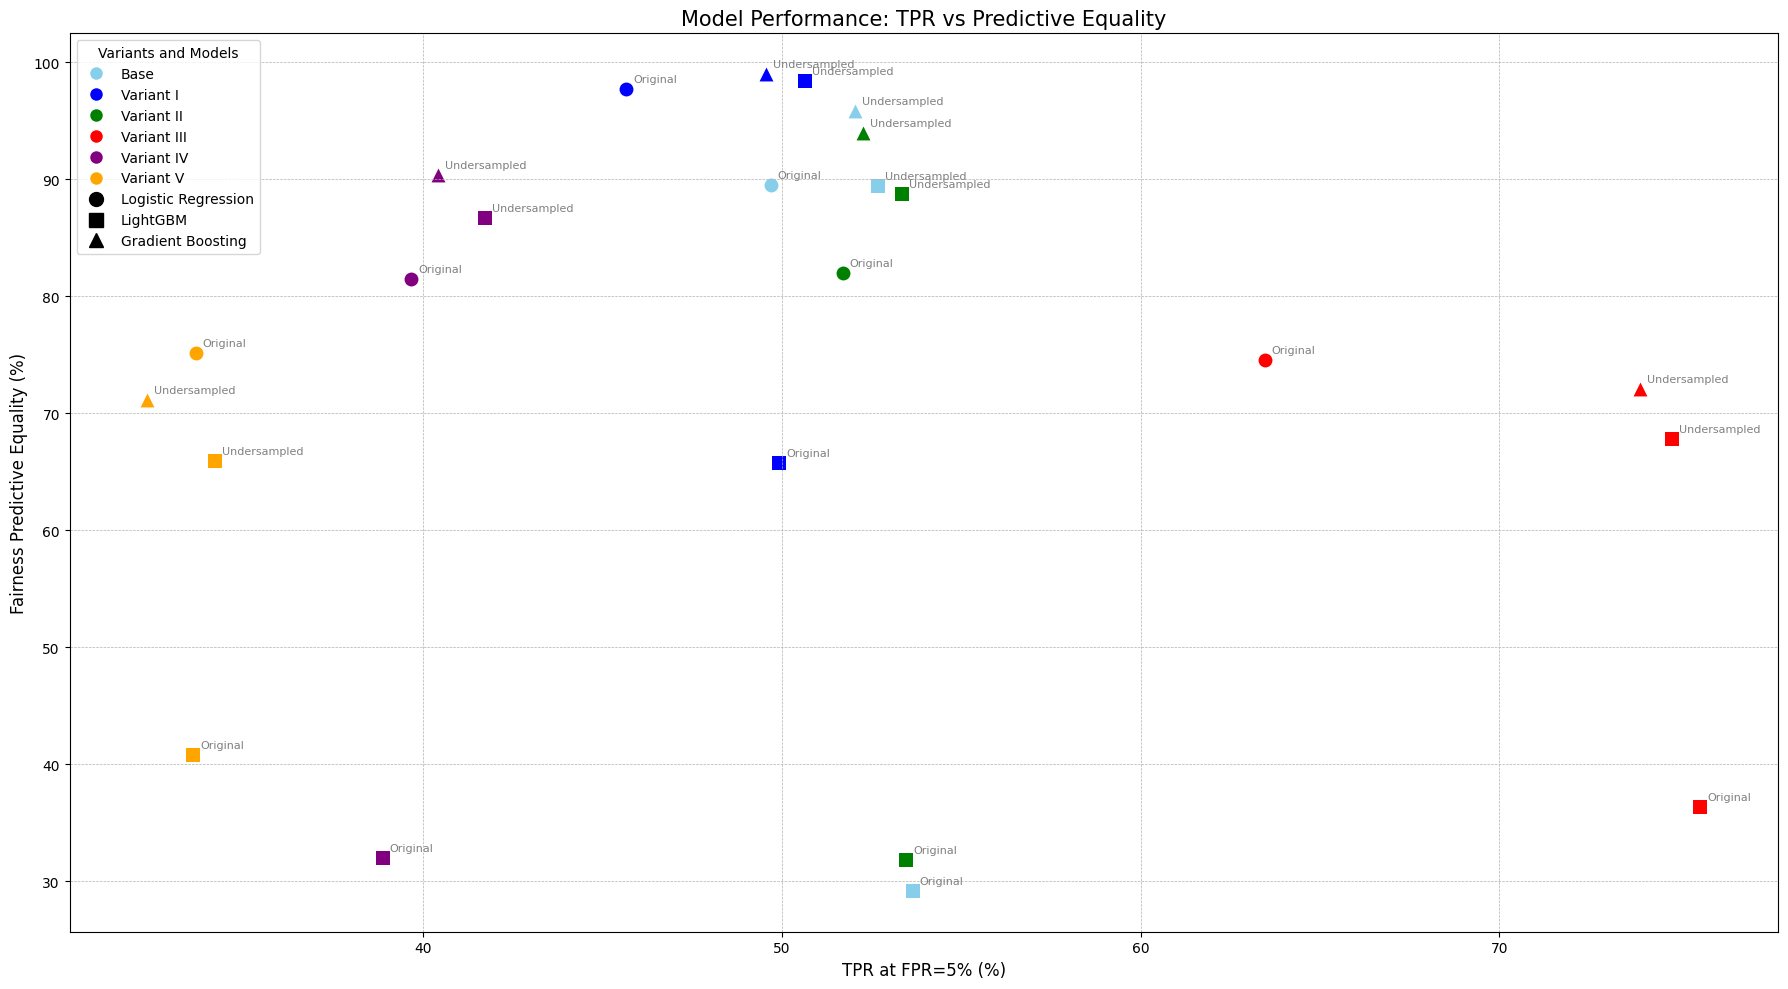

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define color palette for variants
variant_colors = {
    'Base': 'skyblue',
    'Variant I': 'blue',
    'Variant II': 'green',
    'Variant III': 'red',
    'Variant IV': 'purple',
    'Variant V': 'orange'
}

# Data setup
data = {
    'Original': {
        'Logistic Regression': [
            {'Variant': 'Base', 'TPR': 49.69, 'PE': 89.52},
            {'Variant': 'Variant I', 'TPR': 45.66, 'PE': 97.72},
            {'Variant': 'Variant II', 'TPR': 51.70, 'PE': 82.02},
            {'Variant': 'Variant III', 'TPR': 63.46, 'PE': 74.58},
            {'Variant': 'Variant IV', 'TPR': 39.67, 'PE': 81.51},
            {'Variant': 'Variant V', 'TPR': 33.67, 'PE': 75.17}
        ],
        'LightGBM': [
            {'Variant': 'Base', 'TPR': 53.65, 'PE': 29.18},
            {'Variant': 'Variant I', 'TPR': 49.93, 'PE': 65.79},
            {'Variant': 'Variant II', 'TPR': 53.47, 'PE': 31.83},
            {'Variant': 'Variant III', 'TPR': 75.60, 'PE': 36.32},
            {'Variant': 'Variant IV', 'TPR': 38.88, 'PE': 32.02},
            {'Variant': 'Variant V', 'TPR': 33.60, 'PE': 40.80}
        ]
    },
    'Undersampled': {
        'Gradient Boosting': [
            {'Variant': 'Base', 'TPR': 52.05, 'PE': 95.82},
            {'Variant': 'Variant I', 'TPR': 49.55, 'PE': 98.99},
            {'Variant': 'Variant II', 'TPR': 52.26, 'PE': 93.99},
            {'Variant': 'Variant III', 'TPR': 73.91, 'PE': 72.05},
            {'Variant': 'Variant IV', 'TPR': 40.42, 'PE': 90.36},
            {'Variant': 'Variant V', 'TPR': 32.32, 'PE': 71.16}
        ],
        'LightGBM': [
            {'Variant': 'Base', 'TPR': 52.68, 'PE': 89.43},
            {'Variant': 'Variant I', 'TPR': 50.66, 'PE': 98.43},
            {'Variant': 'Variant II', 'TPR': 53.34, 'PE': 88.78},
            {'Variant': 'Variant III', 'TPR': 74.81, 'PE': 67.81},
            {'Variant': 'Variant IV', 'TPR': 41.74, 'PE': 86.68},
            {'Variant': 'Variant V', 'TPR': 34.20, 'PE': 65.91}
        ]
    }
}

# Marker styles for models
model_markers = {
    'Logistic Regression': 'o',
    'Gradient Boosting': '^',
    'LightGBM': 's'
}

plt.figure(figsize=(18, 10))

# Create lists to track legend elements
variant_legend_elements = []
model_legend_elements = []

# Plot each dataset and model
for dataset_type, models in data.items():
    for model_name, variants in models.items():
        for variant_data in variants:
            variant_name = variant_data['Variant']
            marker = model_markers[model_name]

            # Plotting the points without edgecolors
            scatter = plt.scatter(
                variant_data['TPR'],
                variant_data['PE'],
                c=variant_colors[variant_name],
                marker=marker,
                s=100,
                linewidth=0  # Removed edgecolor by setting linewidth to 0
            )

            # Create legend elements for variants
            if variant_name not in [item.get_label() for item in variant_legend_elements]:
                variant_legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=variant_colors[variant_name], markersize=10, label=variant_name))

            # Create legend elements for models
            if model_name not in [item.get_label() for item in model_legend_elements]:
                model_legend_elements.append(plt.Line2D([0], [0], marker=marker, color='black', linestyle='None', markersize=10, label=model_name))

            # Annotate the dataset type ('Original' or 'Undersampled')
            plt.annotate(
                dataset_type,
                (variant_data['TPR'], variant_data['PE']),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=8,
                color='gray'
            )

# Title and labels
plt.title('Model Performance: TPR vs Predictive Equality', fontsize=15)
plt.xlabel('TPR at FPR=5% (%)', fontsize=12)
plt.ylabel('Fairness Predictive Equality (%)', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)

# Combine both variant and model legends inside the graph
plt.legend(handles=variant_legend_elements + model_legend_elements, title='Variants and Models', loc='upper left')

plt.tight_layout()
plt.show()
